# *refellips* Ejemplo para película delgada

Guía corta y simple para ralizar ajustes de de funciones dieléctricas para sistemas estratificado

Una explicación rápida del sofware y sus capacidades se pueden ver en el [video](https://www.youtube.com/watch?v=rcwWq8ANckc)

Una vez entendido todo, es fácil de utilizar pero **sólo se pueden hacer ajusted de grosores de películas**. Toma en cuenta rugosidad y muestras mojadas pero no se determinan funciones dieléctricas.

### Paquetes importantes

In [4]:
from pprint import pprint #Para ver atributos de los objetos

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import refellips
from refellips.dataSE import DataSE
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import RI
from refellips import load_material

In [7]:
import refnx
from refnx.analysis import CurveFitter

In [8]:
print(
    f"refellips: {refellips.version.version}\nrefnx: {refnx.version.version}\nnumpy: {np.version.version}"
)

refellips: 0.0.6
refnx: 0.1.60
numpy: 2.3.3


### Importar datos de la forma: (lambda , ángulo de incidencia, psi, delta)

In [9]:
file = "Bk7Au.csv" # CSV: lda, theta_i, psi, delta
data = DataSE(data=file, delimiter = ",") # Comas pues es un CSV

file = "tmm-data.csv" # CSV: wavelength, aoi, psi, delta
data = DataSE(data=file, delimiter = ",") # Comas pues es un CSV
                                          # Podemos acceder a la información con las banderas: .data, .wavelenght, .aoi, .psi, .delta
                                          # Más en https://refellips.readthedocs.io/en/main/refellips.dataSE.html

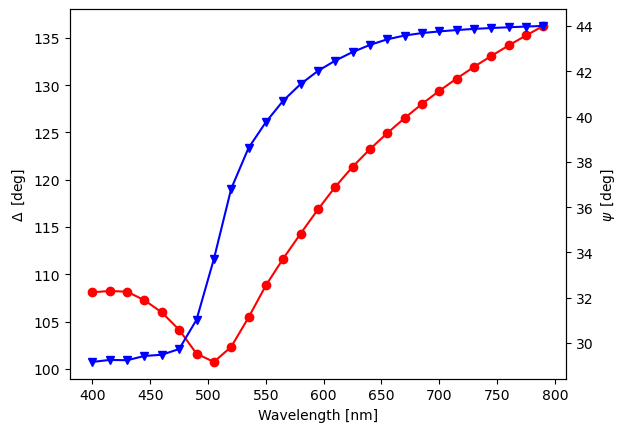

In [10]:
fig, ax = plt.subplots() 
axt = ax.twinx()

ax.plot(data.wavelength, data.delta, ls = '-', color = 'r', marker = "o")
axt.plot(data.wavelength, data.psi, ls = '-', color = 'b', marker = "v")
ax.set(ylabel=r'$\Delta\,$ [deg]', xlabel=r"Wavelength [nm]")
axt.set(ylabel=r"$\psi\,$ [deg]");

### Construir el sistema estratificado

In [11]:
glass = RI([1.5,0.])         # Así se define un índice de refacción constante
gold = load_material("gold") # Probablemente JC
air = RI([1.,0.])

glass.name = "Glass"
gold.name = "Au"
air.name = "Air"

# Como el proceso de fitting es en armstrongs, hay que seleccionar el grosr de las películas en esa unidad
gold_layer = gold(350.)  # Grosor de la película inicial micras (350 a = 35 nm)
gold_layer.thick.setp(vary=True, bounds=(50., 1000.)) # Indicar que sí se varía este parámetro para el análisis y en qué rangos

struc = air() | gold_layer | glass() # Incidencia en aire, pasa a película de oro, termina en vidrio: estructura 3 medios
model = ReflectModelSE(struc)

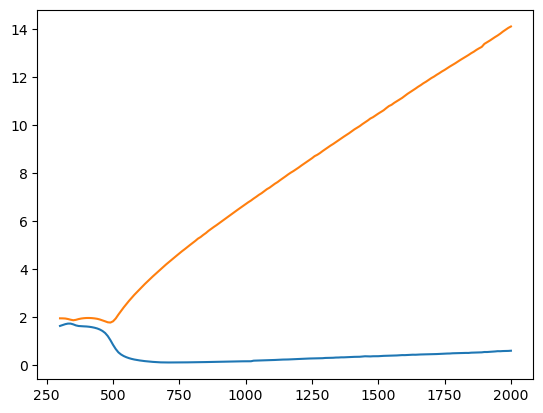

In [12]:
# Así se tiene acceso a los datos del ojeto RI
# Para ver todos: pprint(vars(gold))
fig, ax = plt.subplots() 
ax.plot(gold._wav, gold._RI, gold._wav, gold._EC)


## Ajuste de datos
### Modelo y primera iteración

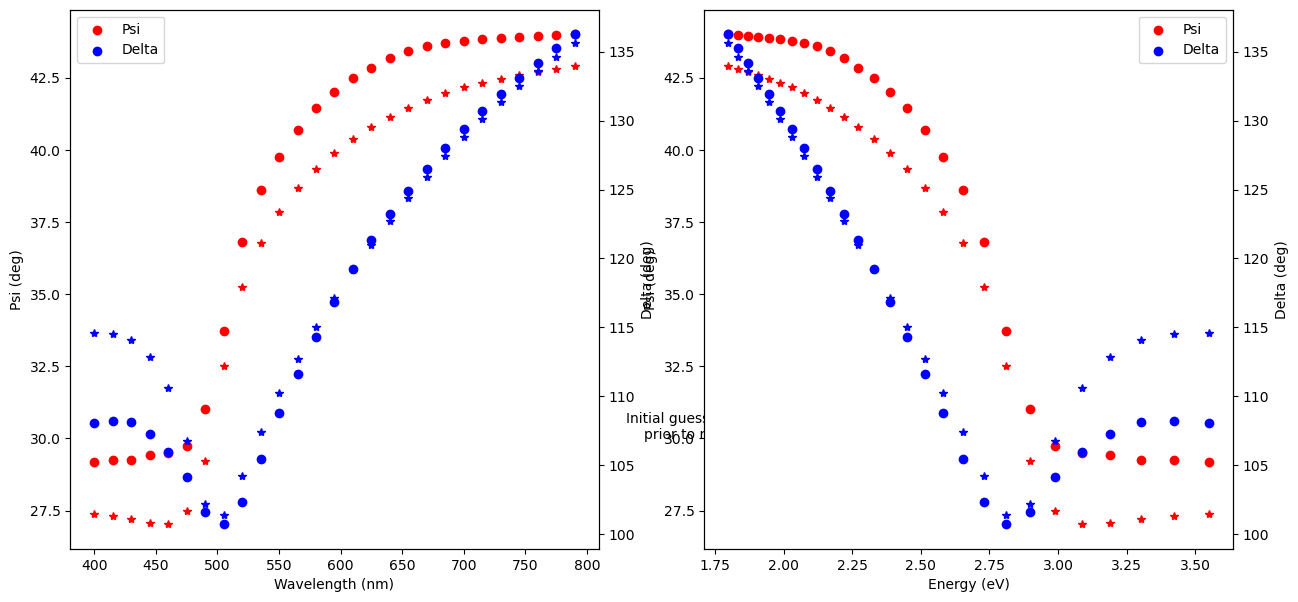

In [23]:
# Create a figure with 1 rows and 2 columns of subplots
fig, ax = plt.subplots(1,2,figsize=(15, 7))
axtlda = ax[0].twinx()
axteV = ax[1].twinx()

for idx, wav in enumerate(np.unique(data.wavelength)):
    lda, aoi, d_psi, d_delta = list(data.unique_wavelength_data())[idx]  # Cambie psi y delta poruqe no queda con lo del paper...
    hw = 1420/lda

    psi, delta = model(np.c_[np.ones_like(aoi) * lda, aoi])
    ax[0].plot(lda, psi, color="r", marker = "*", markersize = 6)
    ax[1].plot(hw, psi, color="r",  marker = "*", markersize = 6)
    axtlda.plot(lda, delta, color="b",  marker = "*", markersize = 6)
    axteV.plot(hw, delta, color="b", marker = "*", markersize = 6)

    plda = ax[0].scatter(lda, d_psi, color="r", marker = 'o')
    dlda = axtlda.scatter(lda, d_delta, color="b", marker = 'o')
    peV = ax[1].scatter(hw, d_psi, color="r", marker = 'o')
    deV = axteV.scatter(hw, d_delta, color="b", marker = 'o')

ax[0].text(
    900,
    30,
    "Initial guess parameters\nprior to refinement",
    ha="center",
    fontsize=10,
)
ax[0].legend(handles=[plda, dlda], labels=["Psi", "Delta"])
ax[1].legend(handles=[peV, deV], labels=["Psi", "Delta"])

ax[0].set(ylabel="Psi (deg)", xlabel="Wavelength (nm)")
ax[1].set(ylabel="Psi (deg)", xlabel="Energy (eV)")
axtlda.set(ylabel="Delta (deg)");
axteV.set(ylabel="Delta (deg)");

In [24]:
objective = ObjectiveSE(model, data)

In [26]:
objective.residuals()

array([-1.77927467, -1.94048456, -2.03104483, -2.34657304, -2.45617307,
       -2.26016193, -1.79694762, -1.21095984, -1.58130622, -1.86141514,
       -1.9144612 , -2.04113887, -2.09185566, -2.12770659, -2.09520933,
       -2.06308584, -2.01256962, -1.94780082, -1.8397482 , -1.71479076,
       -1.59520244, -1.50445125, -1.41440314, -1.32892464, -1.24610648,
       -1.18297372, -1.11736406,  6.50199042,  6.31852431,  5.91678693,
        5.61603808,  4.67480489,  2.64620727,  0.55487821,  0.67747842,
        1.90171412,  1.97145746,  1.40895047,  1.08614086,  0.75234091,
        0.30082795,  0.09911715,  0.39021561,  0.49884608,  0.5755605 ,
        0.62198192,  0.6081292 ,  0.58539077,  0.59399035,  0.57529801,
        0.57543497,  0.56547414,  0.61036229,  0.62238307])

### Fitting

In [27]:
fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

Text(700, 29, 'Model with refined\nparameters')

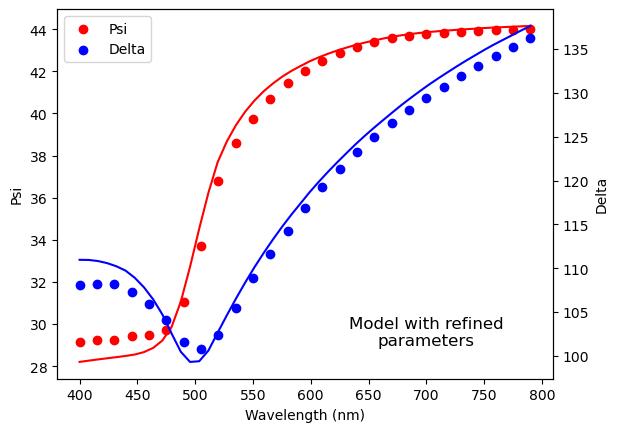

In [28]:
fig, ax = objective.plot()
ax.text(700, 29, "Model with refined\nparameters", ha="center", fontsize=12)

In [29]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:      'Au'      
<Parameter: 'Au - thick'  , value=531.248 +/- 22.6 , bounds=[50.0, 1000.0]>
<Parameter: 'Au - rough'  , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'Au - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]>
_________________________________________________________________